## Network analysis notebook

### Republican likes network

In [1]:
import tweepy
import json
import pickle
import os
import pandas as pd
import networkx as nx

from code import utils, pipelines, graph
from code.representative import Representative

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
with open('data/republican_likes.pkl', 'rb') as f:
    rep_likes = pickle.load(f)

In [11]:
names_li = [r[0] for r in rep_likes]
len(names_li)

250

In [12]:
names_rt = os.listdir('data/rep')
names_rt = list(filter(lambda x: not x.startswith('.'), names_rt))
len(names_rt)

250

In [13]:
republican_network = graph.Political_Graph(names_rt)

In [14]:
republican_network.add_like_weights(rep_likes, 1)

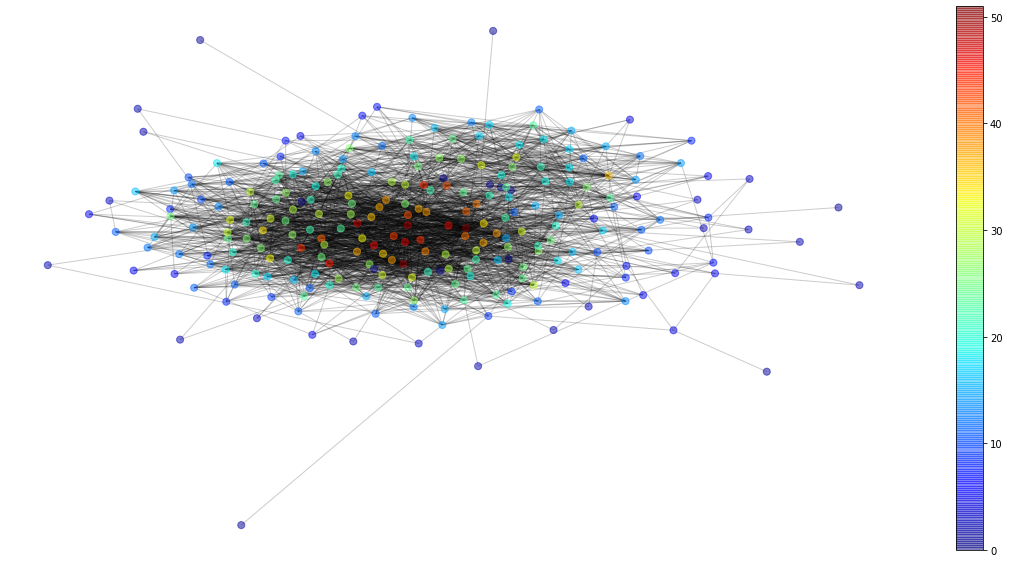

In [15]:
republican_network.draw_graph(layout=nx.kamada_kawai_layout)

In [16]:
nx.is_connected(republican_network.graph)

False

In [17]:
nx.is_directed(republican_network.graph)

False

In [18]:
republican_network.get_isolated_nodes()

['GeorgeHolding',
 'PaulMitchell4us',
 'CaptClayHIggins',
 'DavidKustoff',
 'LindsayGrahamSC',
 'PeteOlson',
 'GregForMontana',
 'RepMcClintock']

In [19]:
republican_network.delete_isolated_nodes()

In [20]:
components = list(nx.connected_components(republican_network.graph))

In [21]:
list(map(len, components))

[242]

In [22]:
nx.diameter(republican_network.graph)

6

In [23]:
sorted(list(nx.betweenness_centrality(republican_network.graph).items()), key=lambda x: -x[1])[:10]

[('SteveScalise', 0.14694191692589012),
 ('GOPLeader', 0.11750068418275653),
 ('RepBradWenstrup', 0.02183893490825684),
 ('SenatorTimScott', 0.021646263821956977),
 ('RepKevinBrady', 0.01973333638398159),
 ('RepDonBacon', 0.019508645422895193),
 ('RepDougCollins', 0.01855693475313797),
 ('SenTedCruz', 0.018466365253824973),
 ('cathymcmorris', 0.01777494208440251),
 ('SenThomTillis', 0.01741061719936299)]

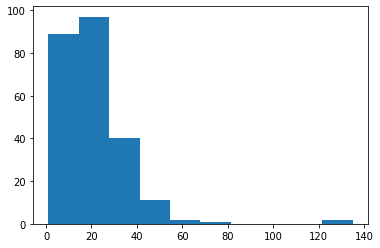

In [24]:
plt.hist(nx.get_node_attributes(republican_network.graph, 'count').values())
plt.show()

### Republican interactions

In [2]:
data = pd.read_csv('data/representatives.csv', index_col='Twitter')
data.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@SenShelby,Alabama,Senator,Richard Shelby,R,SenShelby
@DougJones,Alabama,Senator,Doug Jones,D,DougJones
@RepByrne,Alabama 1st District,Representative,"Byrne, Bradley",R,RepByrne
@RepMarthaRoby,Alabama 2nd District,U.S. Representative,"Roby, Martha",R,RepMarthaRoby
@RepMikeRogersAL,Alabama 3rd District,U.S. Representative,"Rogers, Mike",R,RepMikeRogersAL


In [3]:
data_groups = data.groupby('Party')

republicans = data_groups.get_group('R')
democrats = data_groups.get_group('D')

In [22]:
republicans.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@SenShelby,Alabama,Senator,Richard Shelby,R,SenShelby
@RepByrne,Alabama 1st District,Representative,"Byrne, Bradley",R,RepByrne
@RepMarthaRoby,Alabama 2nd District,U.S. Representative,"Roby, Martha",R,RepMarthaRoby
@RepMikeRogersAL,Alabama 3rd District,U.S. Representative,"Rogers, Mike",R,RepMikeRogersAL
@Robert_Aderholt,Alabama 4th District,U.S. Representative,"Aderholt, Robert",R,Robert_Aderholt


In [23]:
democrats.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@DougJones,Alabama,Senator,Doug Jones,D,DougJones
@RepTerriSewell,Alabama 7th District,U.S. Representative,"Sewell, Terri A.",D,RepTerriSewell
@SenatorSinema,Arizona,U.S. Senator,"Sinema, Kyrsten",D,SenatorSinema
@TomOHalleran,Arizona 1st District,U.S. Representative,"O'Halleran, Tom",D,TomOHalleran
@RepKirkPatrick,Arizona 2nd District,U.S. Representative,"Kirkpatrick, Ann",D,RepKirkPatrick


In [24]:
def get_corpus(representatives):
    corpus = defaultdict(int)

    for rep in representatives:
        for hashtag in rep.hashtags:
            corpus[hashtag] += 1
            
    return corpus

In [4]:
republican_representatives = []

for index, row in republicans.iterrows():
    republican_representatives.append(Representative(*row))

In [6]:
for rep in republican_representatives:
    rep.parse_user('data/rep/')

In [17]:
democrat_representatives = []

for index, row in democrats.iterrows():
    democrat_representatives.append(Representative(*row))

In [18]:
for rep in democrat_representatives:
    rep.parse_user('data/dem/')

In [25]:
republican_corpus = get_corpus(republican_representatives)
democrat_corpus = get_corpus(democrat_representatives)

In [26]:
sorted(list(republican_corpus.items()), key=lambda x: x[1], reverse=True)[:10]

[('covid19', 3430),
 ('coronavirus', 1236),
 ('ppp', 616),
 ('paycheckprotectionprogram', 580),
 ('usmca', 521),
 ('ksleg', 446),
 ('ks02', 428),
 ('scotus', 386),
 ('sotu', 386),
 ('china', 384)]

In [27]:
sorted(list(democrat_corpus.items()), key=lambda x: x[1], reverse=True)[:10]

[('covid19', 6084),
 ('heroesact', 1750),
 ('2020census', 1585),
 ('forthepeople', 733),
 ('coronavirus', 658),
 ('dontmesswithusps', 642),
 ('justiceinpolicing', 521),
 ('vote', 454),
 ('utpol', 453),
 ('scotus', 449)]